In [1]:
import math
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.figure_factory as ff

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold

from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import silhouette_score, silhouette_samples, mean_squared_error, mean_absolute_error, r2_score

In [2]:
# path = '/content/content/MyDrive/[ML DL] data/[Dacon]전력사용량 예측 AI 경진대회/'
path = ''

# train = pd.read_csv(path + 'Train_for_model.csv', encoding='utf-8')
# train['date_time'] = pd.to_datetime(train['date_time'])
# test = pd.read_csv(path + 'Test_for_model.csv', encoding='utf-8')
# test['date_time'] = pd.to_datetime(test['date_time'])

train = pd.read_csv(path + 'train.csv', encoding='cp949')
train['date_time'] = pd.to_datetime(train['date_time'])
test = pd.read_csv(path + 'test.csv', encoding='cp949')
test['date_time'] = pd.to_datetime(test['date_time'])


test = test.interpolate()

In [3]:
train_col_name = ['num', 'date_time', 'y', 'temp', 'wind', 'humidity', 'rain', 'sun', 'cold_system', 'sun_system']
test_col_name = ['num', 'date_time', 'temp', 'wind', 'humidity', 'rain', 'sun', 'cold_system', 'sun_system']

train = pd.DataFrame(train.values, columns=train_col_name)
test = pd.DataFrame(test.values, columns=test_col_name)

## Preprocessing

In [4]:
train[['num', 'cold_system','sun_system']]
ice={}
hot={}
count=0
for i in range(0, len(train), len(train)//60):
    count +=1
    ice[count]=train.loc[i,'cold_system']
    hot[count]=train.loc[i,'sun_system']

for i in range(len(test)):
    test.loc[i, 'cold_system']=ice[test['num'][i]]
    test.loc[i, 'sun_system']=hot[test['num'][i]]

In [5]:
def get_pow(series):
    return math.pow(series, 0.15)

def holiday(x):
    if x.weekday() == 5 or x.weekday() == 6:
        return 1
    elif str(x.date()) == '2020-08-17':
        return 1
    else: 
        return 0

def preprocessing(df):
    df['weekday'] = df.date_time.apply(lambda x: x.weekday())
    df['hour'] = df.date_time.apply(lambda x: int(str(x.time())[:2]))
    df['holiday'] = df['date_time'].apply(lambda x: holiday(x))
    df['perceived_temperature'] = 13.12 + 0.6215*df['temp'] - 11.37*df['wind'].apply(get_pow) + 0.3965*df['wind'].apply(get_pow)*df['temp']
    df['discomfort_index'] = 1.8*df['temp'] - 0.55*(1-df['humidity']/100)*(1.8*df['temp']-26) + 32
#     df['monday'] = df['weekday'].apply(lambda x: 1 if x == 0 else 0)
    df.loc[:, 'rain'] = df.loc[:, 'rain'].apply(lambda x: 0 if x == 0 else 1)
    return df

In [6]:
train = preprocessing(train)
test = preprocessing(test)

## Clustering

In [7]:
# def cluster_evaluate(cluster_df, n_cluster):
#     dic = {}
#     inertia_arr = []
    
#     scaler = StandardScaler()
#     result = scaler.fit_transform(cluster_df)
#     data_scaled = pd.DataFrame(result)
    
#     pca = PCA(n_components=2)
#     result = pca.fit_transform(data_scaled)
#     df = pd.DataFrame(result, columns=["x", "y"])
    
#     print(f'\nPCA explain: {np.sum(pca.explained_variance_ratio_):.4f}\n')
    
#     scaler = StandardScaler()
#     result = scaler.fit_transform(df)
    
#     markers = ['o', 's', '^', 'P']
#     fig, axs = plt.subplots(figsize=(15,4), ncols=4)

#     for ax, i in enumerate(n_cluster):
#         df = pd.DataFrame(result, columns=["x", "y"])
        
#         kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
#         kmeans.fit(result)
        
#         interia = kmeans.inertia_
#         inertia_arr.append(interia)
        
#         pred_cluster = kmeans.predict(result)
#         df['cluster_label'] = pred_cluster

#         score_samples = silhouette_samples(result, df['cluster_label'])
#         df['silhouette_coeff'] = score_samples

#         mean_score = silhouette_score(result, df['cluster_label'])
        
#         cluster_unique = df['cluster_label'].unique()
#         axs[ax].set_title('n_cluster: {}\nSilhouette: {:.4f}'.format(i, mean_score))
        
#         for j in cluster_unique:
#             cluster_target = df[df['cluster_label'] == j]
#             axs[ax].scatter(cluster_target['x'], cluster_target['y'],
#                             marker=markers[ax])
        
#         dic['kmeans'+str(i)] = df
#     plt.figure(figsize=(10, 5))
#     plt.plot(n_cluster, inertia_arr)
#     plt.title('Elbow Method')
#     plt.xlabel('k')
#     plt.ylabel('inertia')
    
#     plt.show()
    
#     return dic

In [8]:
# train_37 = train[train['num'] == 37]
# y = train_37['y'].reset_index(drop=True)

# knn_n_cluster = [3, 4, 5, 6]
# hour_y = np.array(y).reshape(-1, 24).T

# cluster_dic = cluster_evaluate(hour_y, knn_n_cluster)

In [9]:
# cluster_num = cluster_dic['kmeans5']['cluster_label']

# hour_df = pd.DataFrame(train.hour.unique(), columns=['hour'])
# hour_df['cluster'] = cluster_num

In [10]:
# train = train.merge(hour_df, how='left', on='hour')
# test = test.merge(hour_df, how='left', on='hour')

In [11]:
# #군집별 가중치 부여

# lst = []
# p_lst = []

# for i in range(5):
#     m = train[(train['num'] == 37) & (train['cluster'] == i)]['y'].mean()
#     lst.append(m)

# for i in range(5):
#     p = train[(train['num'] == 37) & (train['cluster'] == i)]['y'].mean() / np.sum(lst)
#     p_lst.append(p)

# train['cluster_weight'] = train.cluster.apply(lambda x: p_lst[x])
# test['cluster_weight'] = test.cluster.apply(lambda x: p_lst[x])

## Train Test Split

In [12]:
# def train_test_split(df):
#     train_37 = df[df['num'] == 37]
#     y = train_37['y'].reset_index(drop=True)
#     X = train_37.drop(['date_time', 'y', 'num', 'cold_system', 'sun_system'], axis = 1).reset_index(drop=True)
#     y = y.astype('float32')
    
#     return X, y

In [13]:
def feature_label_split(df):
    y = df['y']
    X = df.drop(['date_time', 'y'], axis = 1).reset_index(drop=True)
    y = y.astype('float32')
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=X['num'], random_state=37)
    
    return X_train, X_test, y_train, y_test

In [14]:
X_train, X_test, y_train, y_test = feature_label_split(train)

In [15]:
test = test.drop('date_time', axis=1)

In [16]:
def data_scaler(train_data, test_data, test):
    scaler = StandardScaler()
    scaler.fit(train_data.drop('num', axis=1))
    X = scaler.transform(train_data.drop('num', axis=1))
    X_test = scaler.transform(test_data.drop('num', axis=1))
    scaled_test = scaler.transform(test.drop('num', axis=1))
    
    col_name = ['temp', 'wind', 'humidity', 'rain', 'sun', 'cold_system', 'sun_system', 'weekday', 'hour', 'holiday',
                'perceived_temperature', 'discomfort_index']
    
    X = pd.DataFrame(X, columns=col_name)
    X_test = pd.DataFrame(X_test, columns=col_name)
    scaled_test = pd.DataFrame(scaled_test, columns=col_name)
    

    num_train = pd.DataFrame(train_data.num.values, columns=['num'])
    num_test = pd.DataFrame(test_data.num.values, columns=['num'])
    num_t = pd.DataFrame(test.num.values, columns=['num'])
    
    
    num_train = num_train.astype('int')
    num_test = num_test.astype('int')
    num_t = num_t.astype('int')
    
    X = pd.concat([X, num_train], axis=1)
    X_test = pd.concat([X_test, num_test], axis=1)
    test = pd.concat([scaled_test, num_t], axis=1)

    return X, X_test, test

In [17]:
X_train, X_test, test = data_scaler(X_train, X_test, test)

y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [18]:
def SMAPE(true, pred):
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred)))*200

## Modeling

In [19]:
def evaluate(X_train, y_train, X_test, model, n_fold):
    n_splits = n_fold
    sfk = StratifiedKFold(n_splits = n_splits, random_state=37)
    models = {}
    
    y_pred = np.zeros(len(X_test))
    fold = 1

    for tr_idx, val_idx in sfk.split(X_train, X_train['num']):
        print('======== {}fold ========'.format(fold))
        feature_train = X_train.iloc[tr_idx, :]
        label_train = y_train[tr_idx]

        feature_val = X_train.iloc[val_idx, :]
        label_val = y_train[val_idx]
        
        model.fit(feature_train, label_train)
        pred = model.predict(X_test)
        
        y_pred += pred / n_splits
        
        models[fold] = model
        
        print(f'''\nMSE: {mean_squared_error(pred, y_test):.4f}
MAE: {mean_absolute_error(pred, y_test):.4f}
RMSE: {np.sqrt(mean_squared_error(pred, y_test)):.4f}
SMAPE: {SMAPE(np.array(y_test), pred):.4f}\n''')

        fold += 1
    plt.figure(figsize=(15,5))
    plt.plot(y_test, 'k' ,label='True')
    plt.plot(y_pred, '--g' ,label='Pred')
    plt.title(f'\nSMAPE: {SMAPE(np.array(y_test), pred):.4f}\nR2_score: {r2_score(pred, y_test):.4f}\n')
    plt.legend()
    plt.show()
    
    return models

======== 1fold ========

MSE: 34496.2749
MAE: 94.7234
RMSE: 185.7317
SMAPE: 4.8299

======== 2fold ========

MSE: 33636.5494
MAE: 94.1243
RMSE: 183.4027
SMAPE: 4.8091

======== 3fold ========

MSE: 33721.0863
MAE: 94.0413
RMSE: 183.6330
SMAPE: 4.7985

======== 4fold ========

MSE: 33464.5686
MAE: 94.3722
RMSE: 182.9332
SMAPE: 4.8335

======== 5fold ========

MSE: 33374.4198
MAE: 93.9584
RMSE: 182.6867
SMAPE: 4.8010

======== 6fold ========

MSE: 33560.2059
MAE: 94.4435
RMSE: 183.1944
SMAPE: 4.8253

======== 7fold ========

MSE: 33841.5125
MAE: 94.5787
RMSE: 183.9606
SMAPE: 4.8344

======== 8fold ========

MSE: 33102.0476
MAE: 93.9585
RMSE: 181.9397
SMAPE: 4.7931

======== 9fold ========

MSE: 34049.7253
MAE: 94.1930
RMSE: 184.5257
SMAPE: 4.8091

======== 10fold ========

MSE: 33561.8907
MAE: 94.3928
RMSE: 183.1990
SMAPE: 4.8129



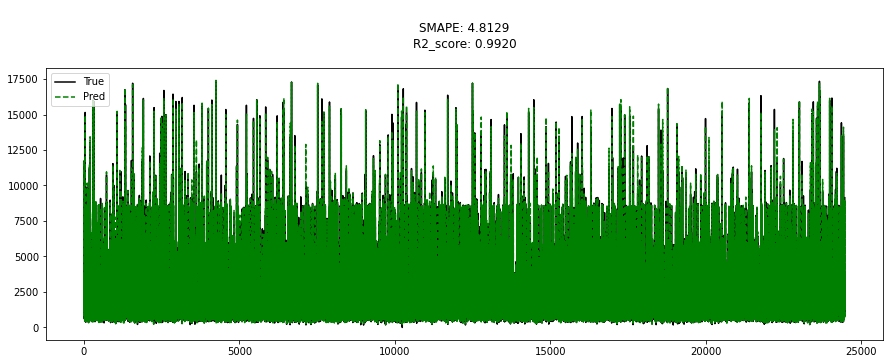

In [20]:
model = RandomForestRegressor(random_state=37)
result_models = evaluate(X_train, y_train, X_test, model, 10)

In [25]:
result_models[1]

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=37, verbose=0, warm_start=False)

In [26]:
submission=pd.read_csv('sample_submission.csv')

for i in range(1, 11):
    submission['answer'] += result_models[i].predict(test)/10

submission

,num_date_time,answer
0,1 2020-08-25 00,8662.749082
1,1 2020-08-25 01,8657.668818
2,1 2020-08-25 02,8654.752832
3,1 2020-08-25 03,8640.412568
4,1 2020-08-25 04,8608.148643
...,...,...
10075,60 2020-08-31 19,4089.394111
10076,60 2020-08-31 20,3766.452473
10077,60 2020-08-31 21,3691.116016
10078,60 2020-08-31 22,3576.022585


In [27]:
submission.to_csv('rf_submission.csv', index=False)

In [22]:
# n_splits = 10
# sfk = StratifiedKFold(n_splits = n_splits, random_state=37)

# y_pred = np.zeros(len(X_test))
# fold = 1

# for tr_idx, val_idx in sfk.split(X, X['num']):
#     print('======== {}fold ========'.format(fold))
#     X_train = X.iloc[tr_idx, :]
#     y_train = y[tr_idx]

#     X_val = X.iloc[val_idx, :]
#     y_val = y[val_idx]
    
#     lgbm = LGBMRegressor(n_estimators = 10000, learning_rate= 0.01,objective = 'mse', random_state=37)
#     lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric= 'rmse', early_stopping_rounds=30, verbose=500)
#     y_pred += lgbm.predict(X_test) / n_splits
#     pred = lgbm.predict(X_test)
    
#     print(f'\nSMAPE: {SMAPE(y_true, pred):.4f}\n')
    
#     fold += 1

# plt.figure(figsize=(15,5))
# plt.plot(y_true, 'k' ,label='True')
# plt.plot(y_pred, '--g' ,label='Pred')
# plt.title(f'\nSMAPE: {SMAPE(y_true, y_pred):.4f}\nR2_score: {r2_score(y_true, y_pred):.4f}\n')
# plt.legend()
# plt.show()